In [62]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline
from text3d2video.pipelines.generative_rendering_pipeline import GrPipeline
from text3d2video.pipelines.new_gr_pipeline import GrPipelineNew
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexGenPipeline

gr_pipe: GrPipelineNew = load_pipeline(GrPipelineNew)

texturing_pipe: TexGenPipeline = TexGenPipeline(
    gr_pipe.vae,
    gr_pipe.text_encoder,
    gr_pipe.tokenizer,
    gr_pipe.unet,
    gr_pipe.scheduler,
    gr_pipe.controlnet,
)

old_gr_pipe = GrPipeline(
    vae=gr_pipe.vae,
    text_encoder=gr_pipe.text_encoder,
    tokenizer=gr_pipe.tokenizer,
    unet=gr_pipe.unet,
    scheduler=gr_pipe.scheduler,
    controlnet=gr_pipe.controlnet,
)

controlnet_pipe = BaseControlNetPipeline(
    vae=gr_pipe.vae,
    text_encoder=gr_pipe.text_encoder,
    tokenizer=gr_pipe.tokenizer,
    unet=gr_pipe.unet,
    scheduler=gr_pipe.scheduler,
    controlnet=gr_pipe.controlnet,
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [64]:
tgt_tag = "mma_20:latest"
tgt_tag = "mv_helmet:latest"
tgt_tag = "ymca_20:latest"
tgt_tag = "mv_helmet_25:latest"
tgt_tag = "owl_zoom:latest"
tgt_tag = 'rumba_zoom_side:latest'
tgt_tag = "rumba_zoom_20:latest"
tgt_tag = 'mv_lion:latest'
tgt_tag = "lion_zoom:latest"
tgt_tag = "mv_cat_statue_25:latest"
tgt_tag = "catwalk_180_20:latest"
tgt_tag = 'flair_20:latest'
tgt_tag = 'handstand_20:latest'
tgt_tag = "joyful_jump_20:latest"
tgt_tag = "rumba_20:latest"
tgt_tag = 'joyful_jump_short:latest'

anim_art = AnimationArtifact.from_wandb_artifact_tag(tgt_tag)
tgt_seq = anim_art.read_anim_seq()

src_tag = 'catwalk_180_src:latest'
src_tag = "ymca_zoom_out:latest"
src_tag = 'rumba_zoom_src:latest'
src_tag = 'owl_zoom_src:latest'
src_tag = 'rumba_zoom_out_src:latest'
src_tag = 'mv_helmet:latest'
src_tag = 'mv_cat_statue:latest'
src_tag = 'human_T_front:latest'
src_tag = 'human_mv:latest'
# src_tag = 'lion_zoom_out_src:latest'

src_seq = AnimationArtifact.from_wandb_artifact_tag(
    src_tag,
).read_anim_seq()

In [100]:
from text3d2video.rendering import render_texture
from text3d2video.util import chw_to_hwc
from text3d2video.utilities.testing_utils import checkerboard_img
from text3d2video.utilities.video_comparison import display_vid, video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool"
input_src_anim = None
input_src_anim = src_seq

def inputs_video(prompt, src_seq, tgt_seq):
    texture = checkerboard_img(return_type="pt", res=500, square_size=30).cuda()
    texture = chw_to_hwc(texture)

    vids = {}

    if src_seq is not None:
        src_frames = render_texture(
            src_seq.meshes,
            src_seq.cams,
            texture,
            src_seq.verts_uvs,
            src_seq.faces_uvs,
            return_pil=True,
        )

        vids["src"] = pil_frames_to_clip(src_frames)

    anim_frames = render_texture(
        tgt_seq.meshes,
        tgt_seq.cams,
        texture,
        tgt_seq.verts_uvs,
        tgt_seq.faces_uvs,
        return_pil=True,
    )

    tgt_vid = pil_frames_to_clip(anim_frames, fps=12)
    vids["tgt"] = tgt_vid

    vids_list = list(vids.values())
    titles = list(vids.keys())
    return video_grid(
        [vids_list], x_labels=titles, padding_mode="slow_down", y_labels=[prompt]
    )

display_vid(inputs_video(prompt, src_seq, tgt_seq))

In [101]:
from text3d2video.pipelines.texturing_pipeline import TexGenConfig

texgen_config = TexGenConfig(
    num_inference_steps=15,
    do_text_and_texture_resampling=True,
    use_prev_clean_tex=True,
    use_update_masks=True,
    use_referecnce_kvs=True,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

out_src = texturing_pipe(
    prompt,
    src_seq,
    conf=texgen_config,
    generator=generator,
)

display_vid(pil_frames_to_clip(out_src.images))

100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


In [102]:
renders = render_texture(tgt_seq.meshes, tgt_seq.cams, out_src.texture, tgt_seq.verts_uvs, tgt_seq.faces_uvs, return_pil=True)

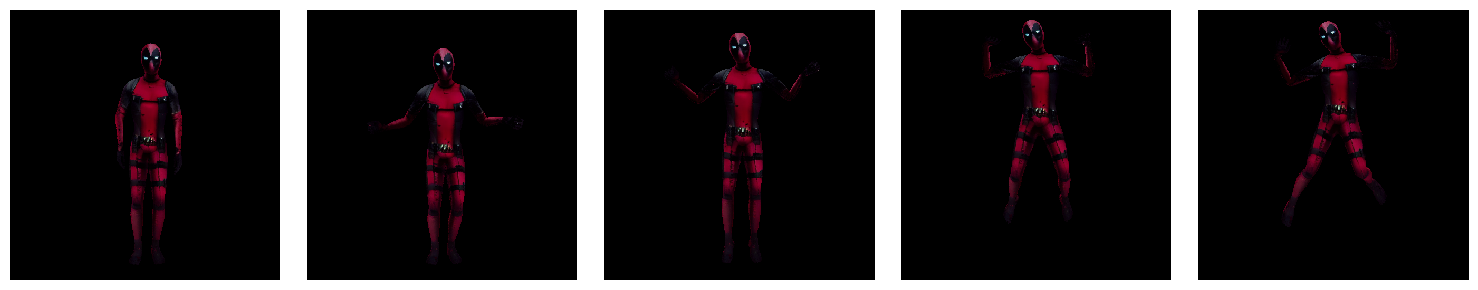

In [103]:
from text3d2video.utilities.ipython_utils import display_ims

display_ims(renders)

In [141]:
from text3d2video.mip import seq_max_uv_res
from text3d2video.noise_initialization import UVNoiseInitializer


t_prime = texturing_pipe.scheduler.timesteps[8]
print(t_prime)

renders_enc = texturing_pipe.encode_images(renders)

uv_res = seq_max_uv_res(tgt_seq)
uv_noise = UVNoiseInitializer(noise_texture_res=uv_res)
noise = uv_noise.initial_noise(tgt_seq.meshes, tgt_seq.cams, tgt_seq.verts_uvs, tgt_seq.faces_uvs)

# noise = torch.randn_like(renders_enc)
initialized_latents = texturing_pipe.scheduler.add_noise(
    renders_enc, noise, t_prime
)

tensor(397)


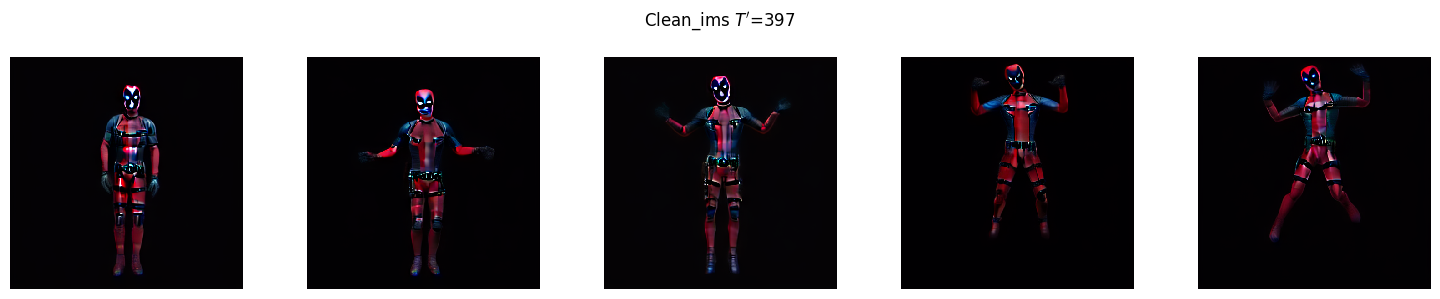

In [142]:
cond_embs, uncond_embs = texturing_pipe.encode_prompt([prompt] * len(initialized_latents))
depth_maps = tgt_seq.render_depth_maps()

noise_pred = texturing_pipe.model_forward_cfg(
    initialized_latents, cond_embs, uncond_embs, t_prime, depth_maps
)
clean_im = texturing_pipe.scheduler.step(
    noise_pred, t_prime, initialized_latents, generator=generator
).pred_original_sample
clean_im = texturing_pipe.decode_latents(clean_im)
display_ims(clean_im, title=f"Clean_ims $T'$={t_prime}")

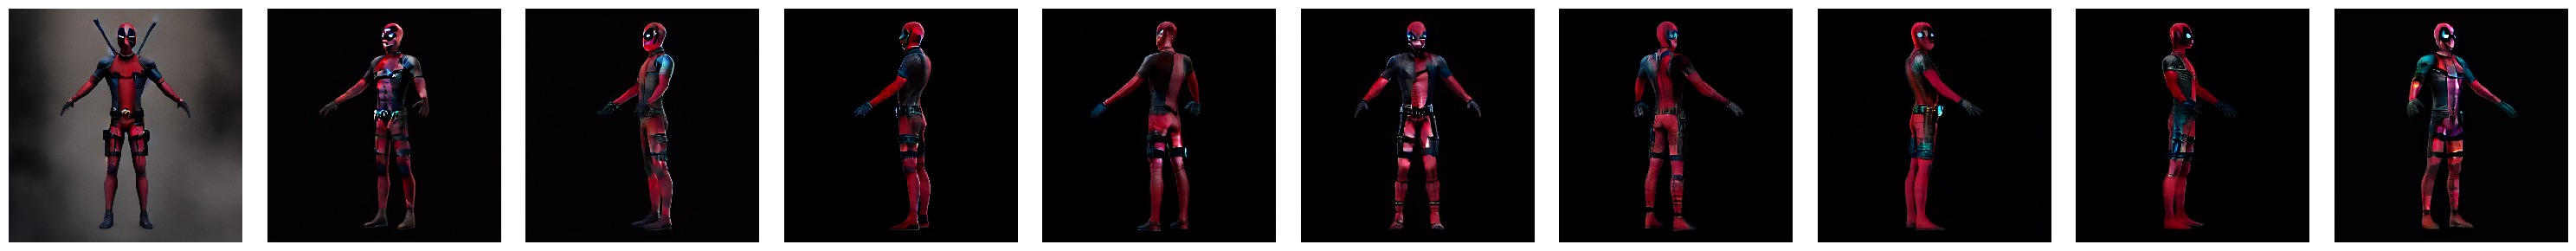

In [ ]:
latents = out_src.latents[t_prime.item()]

cond_embs, uncond_embs = texturing_pipe.encode_prompt([prompt] * len(latents))
depth_maps = src_seq.render_depth_maps()

noise_pred = texturing_pipe.model_forward_cfg(
    latents, cond_embs, uncond_embs, t_prime, depth_maps
)
clean_im = texturing_pipe.scheduler.step(
    noise_pred, t_prime, latents, generator=generator
).pred_original_sample
clean_im = texturing_pipe.decode_latents(clean_im)
display_ims(clean_im)